In [34]:
import pandas as pd
import os
import numpy as np

data_path = os.path.join("eDo", "data", "processed.csv")
df = pd.read_csv(data_path, parse_dates=['DateTime'], index_col='DateTime')

df = df.dropna()
print(df.head())


                         Open      High       Low     Close      Volume  \
DateTime                                                                  
2022-01-25 13:00:00  36519.12  36579.99  36259.10  36498.00  2008.17575   
2022-01-25 14:00:00  36497.39  37149.42  36252.00  36299.99  5493.26524   
2022-01-25 15:00:00  36299.99  36780.00  35967.33  36530.00  3943.20294   
2022-01-25 16:00:00  36530.00  37086.64  36492.48  36837.70  2613.07831   
2022-01-25 17:00:00  36837.70  37481.75  36800.00  37273.33  3299.07838   

                      log_ret  fracdiff  
DateTime                                 
2022-01-25 13:00:00 -0.000579  0.103441  
2022-01-25 14:00:00 -0.005440  0.097746  
2022-01-25 15:00:00  0.006316  0.107048  
2022-01-25 16:00:00  0.008388  0.112089  
2022-01-25 17:00:00  0.011756  0.118196  


In [35]:
train_size = int(len(df) * 0.8)
train_df = df.iloc[:train_size].copy()
test_df  = df.iloc[train_size:].copy()

print(f"Train size: {len(train_df)}, Test size: {len(test_df)}")


Train size: 20136, Test size: 5035


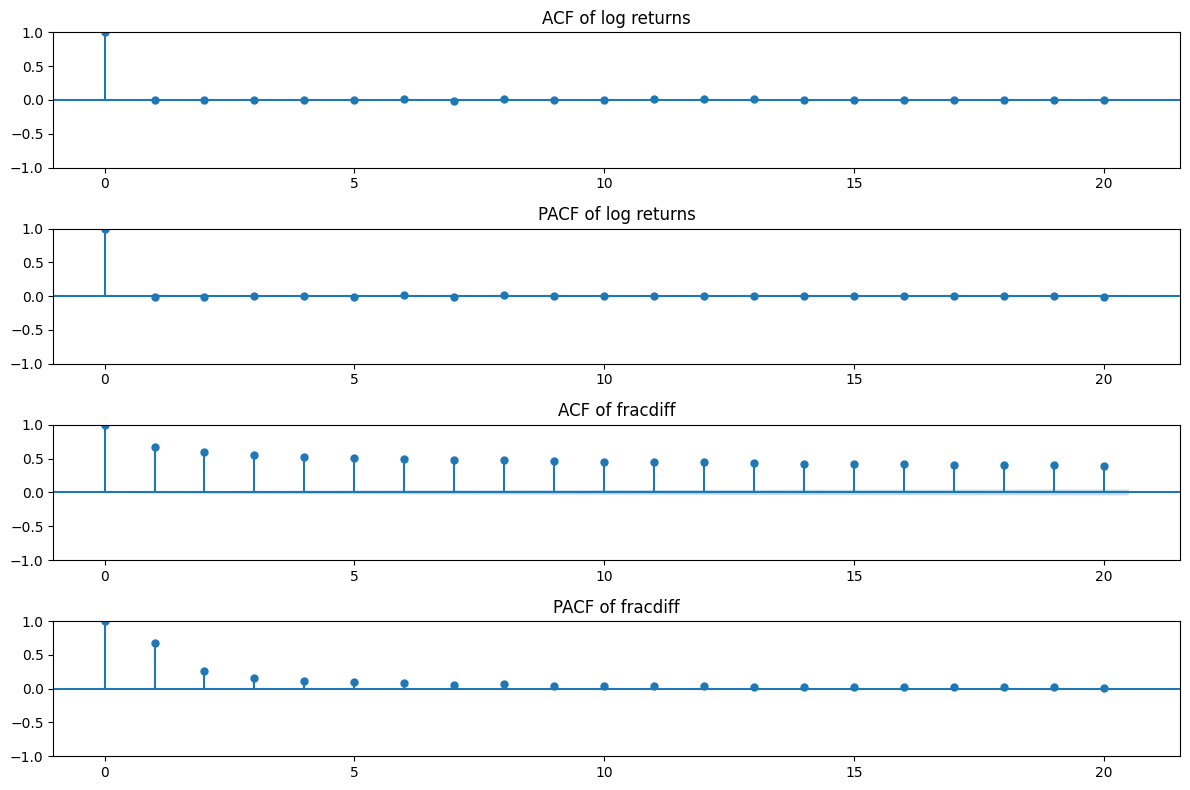

In [36]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

fig, axes = plt.subplots(4, 1, figsize=(12, 8))

plot_acf(train_df['log_ret'], ax=axes[0], lags=20, title="ACF of log returns")
plot_pacf(train_df['log_ret'], ax=axes[1], lags=20, title="PACF of log returns")
plot_acf(train_df['fracdiff'], ax=axes[2], lags=20, title="ACF of fracdiff")
plot_pacf(train_df['fracdiff'], ax=axes[3], lags=20, title="PACF of fracdiff")
plt.tight_layout()
plt.show()


In [4]:
from pmdarima import auto_arima

stepwise_model_logret = auto_arima(
    train_df['log_ret'],
    start_p=1, start_q=1,
    max_p=5, max_q=5,
    d=0,           # because we assume log_ret is already differenced
    seasonal=False,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

print(stepwise_model_logret.summary())


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-150430.941, Time=1.40 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-150433.847, Time=0.65 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-150432.716, Time=0.61 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-150432.730, Time=1.05 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-150432.286, Time=2.56 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 6.275 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                20136
Model:                        SARIMAX   Log Likelihood               75217.924
Date:                Thu, 02 Jan 2025   AIC                        -150433.847
Time:                        13:06:39   BIC                        -150425.937
Sample:                    01-25-2022   HQIC                       -150431.260
                         - 05-13-2024                        

In [5]:
stepwise_model_fracdiff = auto_arima(
    train_df['fracdiff'],
    start_p=1, start_q=1,
    max_p=5, max_q=5,
    d=0,           # because its already fractionally differenced
    seasonal=False,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

print(stepwise_model_fracdiff.summary())


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-149274.275, Time=3.12 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-34856.083, Time=0.52 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.84 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-60337.855, Time=0.98 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-150071.922, Time=3.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.72 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-147839.873, Time=1.74 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-149344.912, Time=2.21 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-149564.857, Time=1.57 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=1.50 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-149628.912, Time=2.28 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-149337.226, Time=19.66 sec

Best model:  ARIMA(2,0,1)(0,0,0)[0]          
Total fit time: 38.182 seconds
                               SARIMAX Results                              

In [6]:
from statsmodels.tsa.arima.model import ARIMA

p, d, q = (2, 0, 1)
fracdiff_model = ARIMA(train_df['fracdiff'], order=(p, d, q)).fit()
print(fracdiff_model.summary())

p, d, q = (0, 0, 0)
log_ret_model = ARIMA(train_df['log_ret'], order=(p, d, q)).fit()
print(log_ret_model.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:465: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:465: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:465: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:612: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:               fracdiff   No. Observations:                20136
Model:                 ARIMA(2, 0, 1)   Log Likelihood               75123.741
Date:                Thu, 02 Jan 2025   AIC                        -150237.481
Time:                        13:07:31   BIC                        -150197.930
Sample:                    01-25-2022   HQIC                       -150224.545
                         - 05-13-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1013      0.001    197.961      0.000       0.100       0.102
ar.L1          1.2652      0.005    235.725      0.000       1.255       1.276
ar.L2         -0.2772      0.005    -55.880      0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:465: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:465: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:465: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                log_ret   No. Observations:                20136
Model:                          ARIMA   Log Likelihood               75218.120
Date:                Thu, 02 Jan 2025   AIC                        -150432.241
Time:                        13:07:35   BIC                        -150416.420
Sample:                    01-25-2022   HQIC                       -150427.067
                         - 05-13-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.196e-05   4.06e-05      0.540      0.589   -5.77e-05       0.000
sigma2      3.328e-05   1.14e-07    293.028      0.000    3.31e-05    3.35e-05
Ljung-Box (L1) (Q):                   0.87   Jarque-

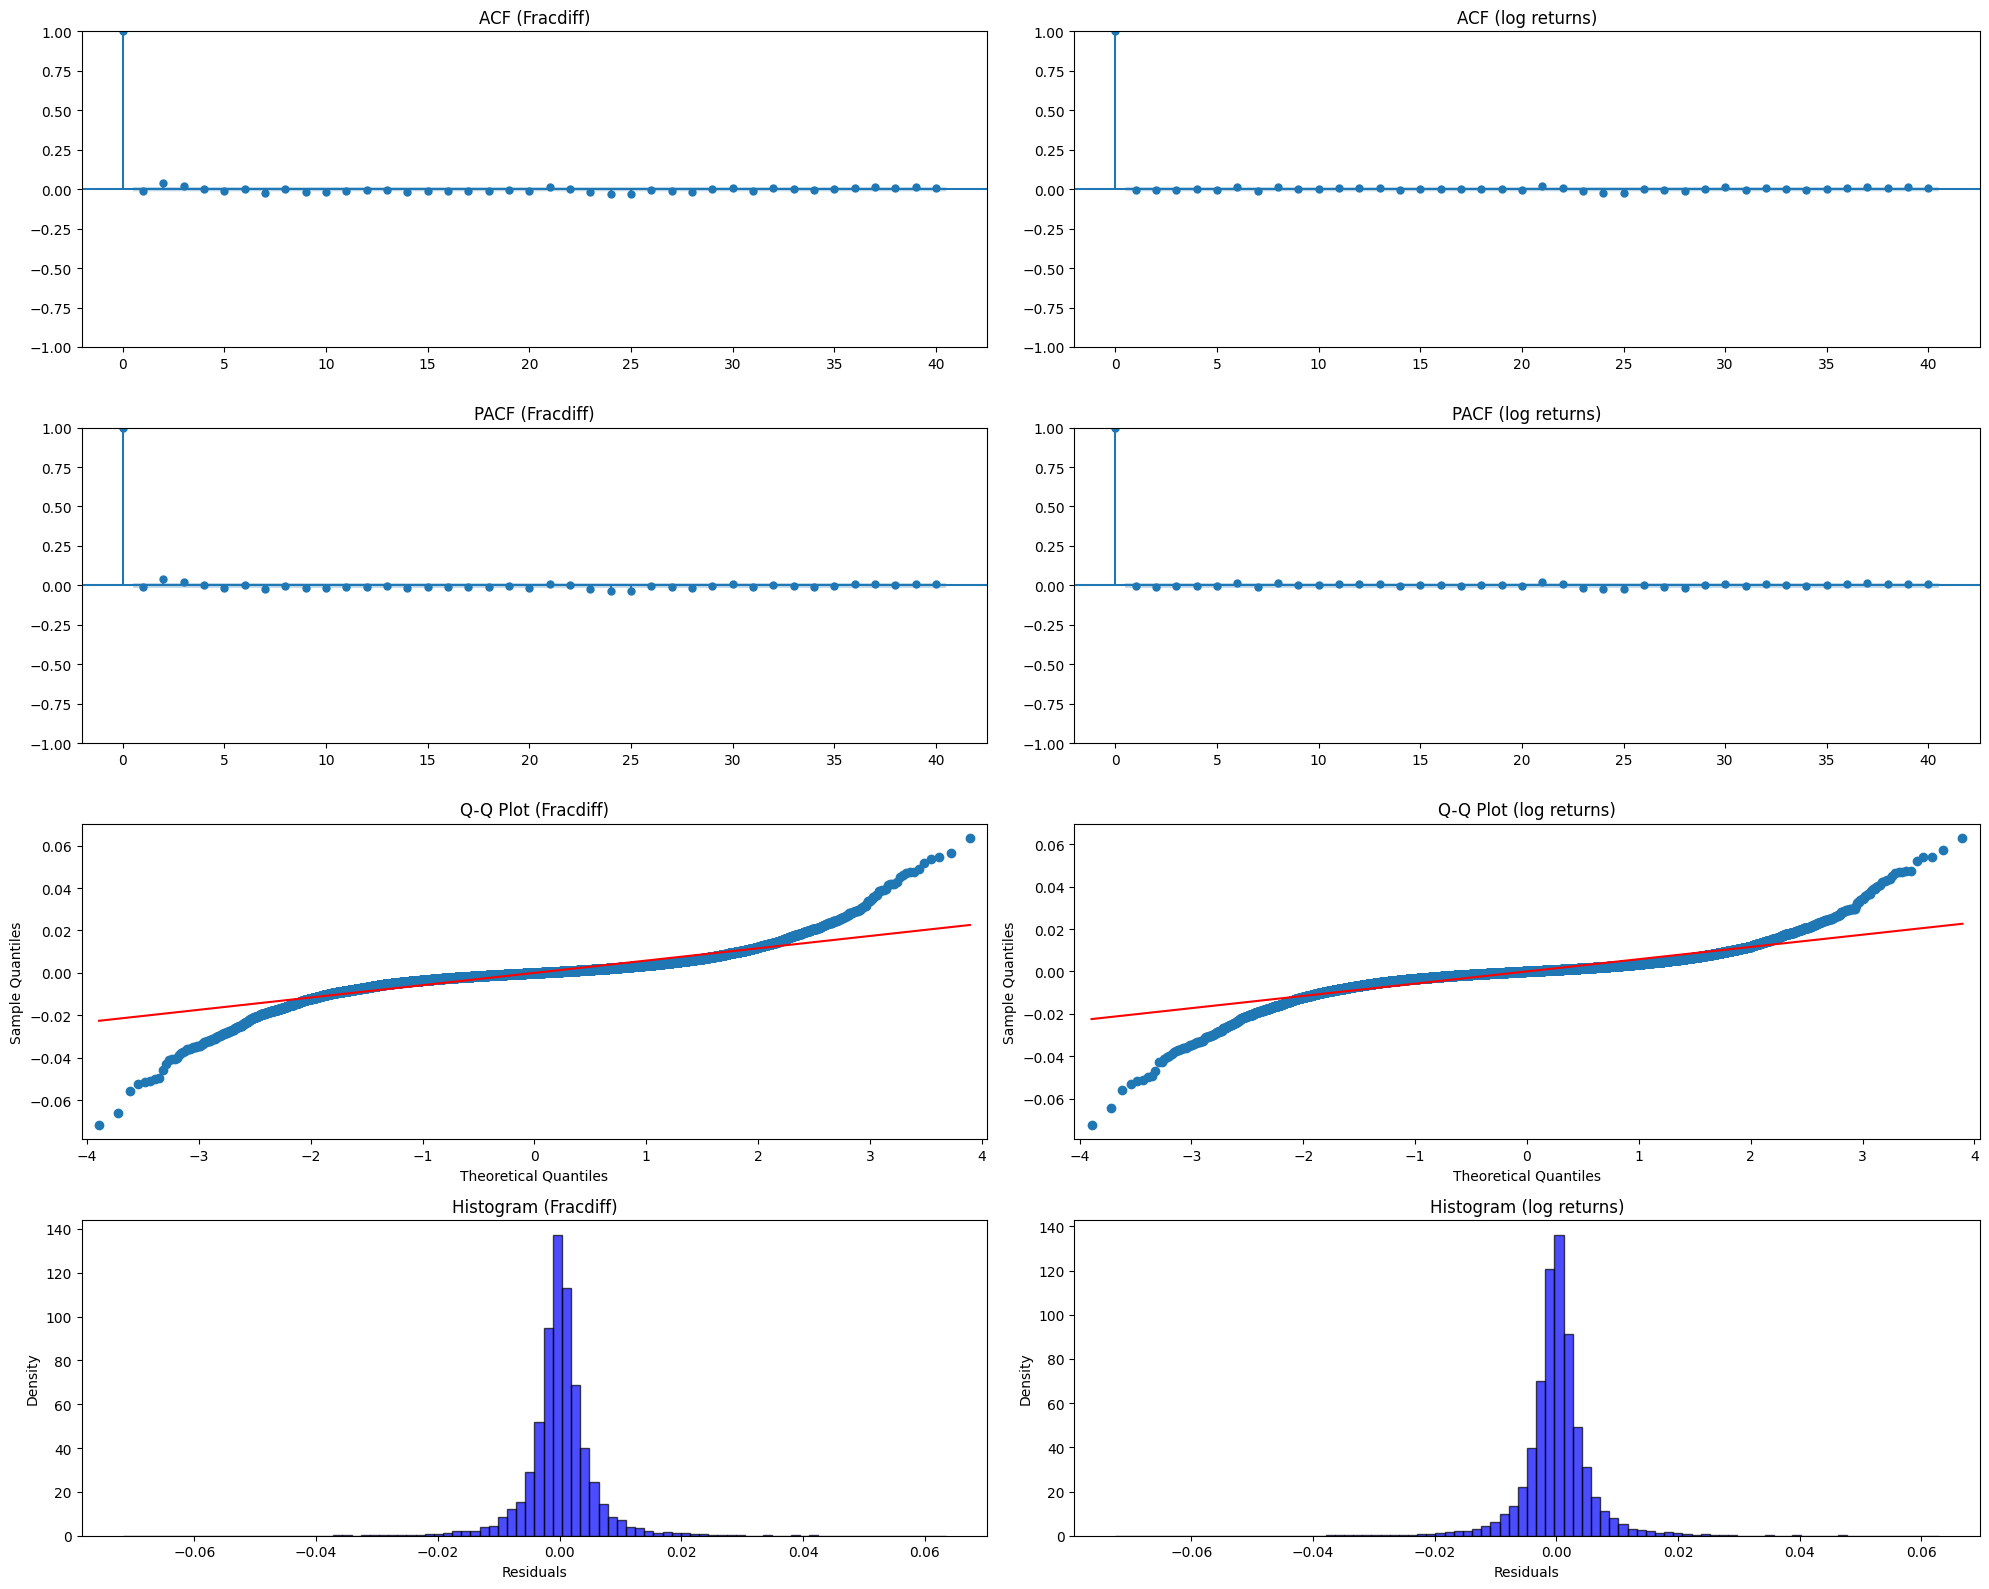

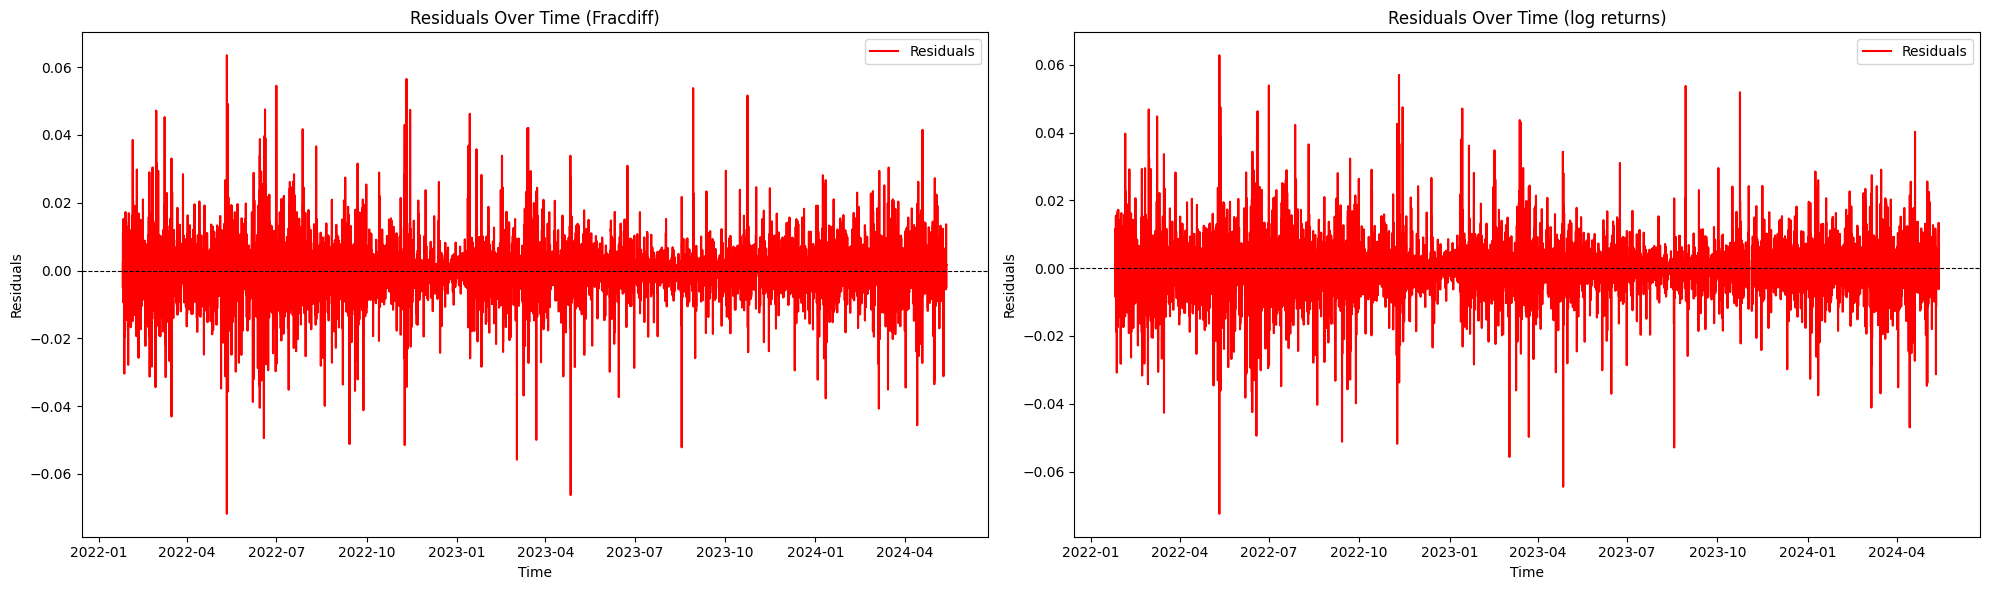

In [7]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm

residuals_fracdiff = fracdiff_model.resid
residuals_log_ret = log_ret_model.resid.dropna()

fig, axes = plt.subplots(4, 2, figsize=(20, 16))

# ACF and PACF for Fracdiff residuals
plot_acf(residuals_fracdiff, ax=axes[0, 0], lags=40, title="ACF (Fracdiff)")
plot_pacf(residuals_fracdiff, ax=axes[1, 0], lags=40, title="PACF (Fracdiff)")

# ACF and PACF for log returns residuals
plot_acf(residuals_log_ret, ax=axes[0, 1], lags=40, title="ACF (log returns)")
plot_pacf(residuals_log_ret, ax=axes[1, 1], lags=40, title="PACF (log returns)")

# Q-Q Plots
sm.qqplot(residuals_fracdiff, line='s', ax=axes[2, 0])
axes[2, 0].set_title("Q-Q Plot (Fracdiff)")
sm.qqplot(residuals_log_ret, line='s', ax=axes[2, 1])
axes[2, 1].set_title("Q-Q Plot (log returns)")

# Residual Histograms
axes[3, 0].hist(residuals_fracdiff, bins=90, density=True, alpha=0.7, color='blue', edgecolor='black')
axes[3, 0].set_title("Histogram (Fracdiff)")
axes[3, 0].set_xlabel("Residuals")
axes[3, 0].set_ylabel("Density")

axes[3, 1].hist(residuals_log_ret, bins=90, density=True, alpha=0.7, color='blue', edgecolor='black')
axes[3, 1].set_title("Histogram (log returns)")
axes[3, 1].set_xlabel("Residuals")
axes[3, 1].set_ylabel("Density")

plt.tight_layout()
plt.show()

# Residual Time Series Plots
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Residuals over time for Fracdiff
axes[0].plot(residuals_fracdiff, label='Residuals', color='red')
axes[0].axhline(y=0, color='black', linestyle='--', linewidth=0.8)
axes[0].set_title("Residuals Over Time (Fracdiff)")
axes[0].set_xlabel("Time")
axes[0].set_ylabel("Residuals")
axes[0].legend()

# Residuals over time for log returns
axes[1].plot(residuals_log_ret, label='Residuals', color='red')
axes[1].axhline(y=0, color='black', linestyle='--', linewidth=0.8)
axes[1].set_title("Residuals Over Time (log returns)")
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Residuals")
axes[1].legend()

plt.tight_layout()
plt.show()


# GARCH

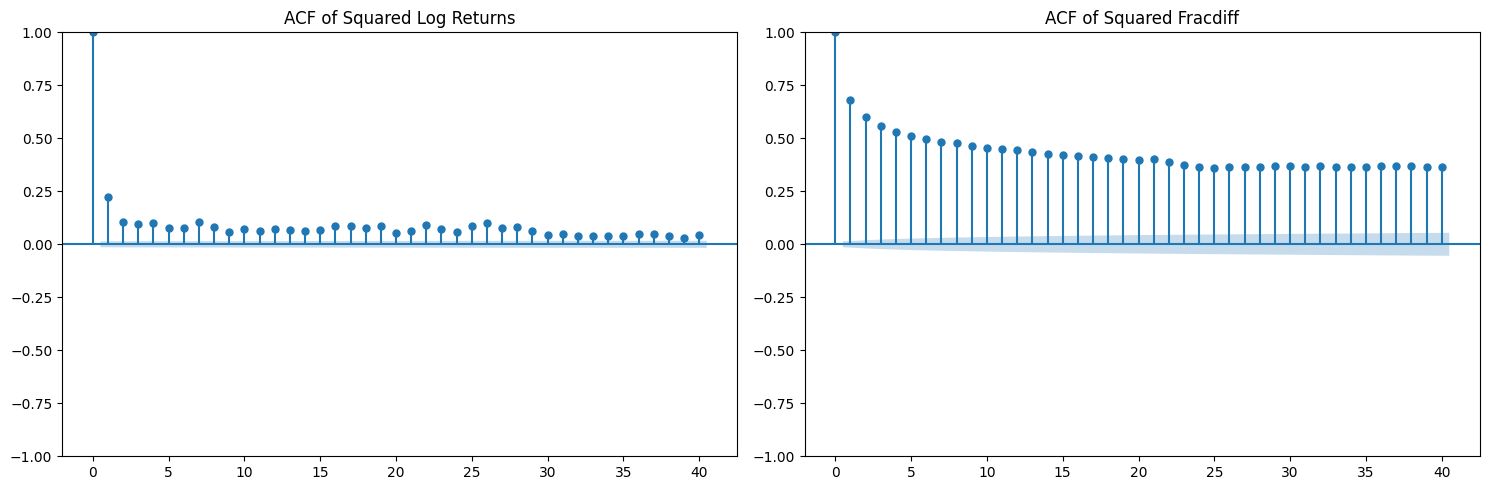

In [8]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

plot_acf(train_df['log_ret']**2, lags=40, 
         title="ACF of Squared Log Returns", ax=axes[0])

plot_acf(train_df['fracdiff']**2, lags=40, 
         title="ACF of Squared Fracdiff", ax=axes[1])

plt.tight_layout()
plt.show()


This means the volatility has tendency to cluster and is present for some time after an event.

In [9]:
from statsmodels.stats.diagnostic import het_arch

arch_test = het_arch(train_df['fracdiff'])
# arch_test returns (LM stat, LM p-value, F-stat, F p-value)
print("ARCH test:", arch_test)

arch_test = het_arch(train_df['log_ret'])
print("ARCH test:", arch_test)


ARCH test: (10665.133068987026, 0.0, 2267.5422162364616, 0.0)
ARCH test: (1409.0169132192302, 1.121160371648046e-296, 151.42598076835466, 9.647509618411445e-308)


# ARIMA + GARCH

In [10]:
import itertools
from arch import arch_model

best_aic = np.inf
best_order = None
best_model = None

p_range = range(1, 6)
q_range = range(1, 6)

arima_resid  = fracdiff_model.resid.dropna()*100

for p, q in itertools.product(p_range, q_range):

        model = arch_model(arima_resid, mean='Zero', vol='GARCH', p=p, q=q)
        res = model.fit(disp='off')
        if res.aic < best_aic:
            best_aic = res.aic
            best_order = (p, q)
            best_model = res

print(f"Best GARCH model order: p={best_order[0]}, q={best_order[1]} with AIC={best_aic}")
print(best_model.summary())


Best GARCH model order: p=1, q=5 with AIC=29153.208103557394
                       Zero Mean - GARCH Model Results                        
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -14569.6
Distribution:                  Normal   AIC:                           29153.2
Method:            Maximum Likelihood   BIC:                           29208.6
                                        No. Observations:                20136
Date:                Thu, Jan 02 2025   Df Residuals:                    20136
Time:                        13:07:38   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
--------------------------------------------------------------------------

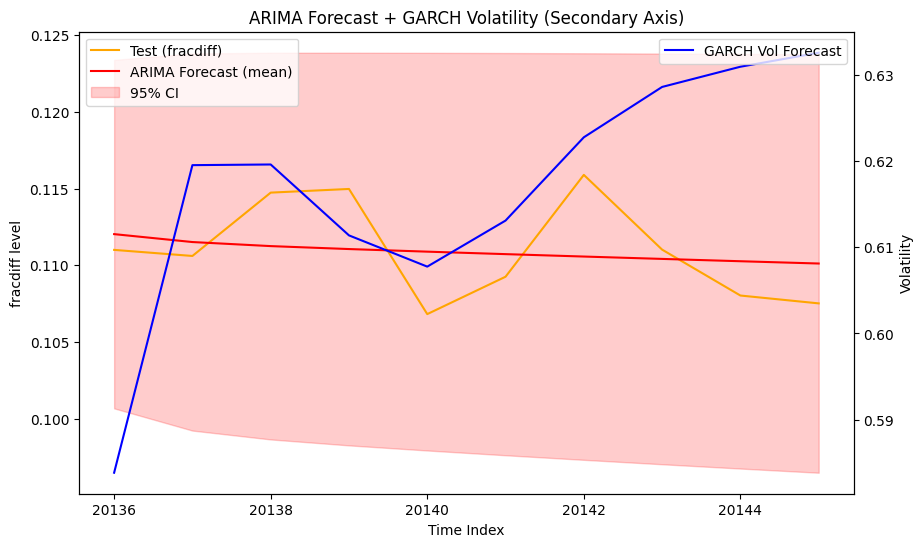

In [11]:
n_test = 10

# ARIMA forecast object
forecast_obj = fracdiff_model.get_forecast(steps=n_test)

# ARIMA point forecast (mean)
arima_mean_pred = forecast_obj.predicted_mean

# Confidence intervals for ARIMA forecast
arima_conf_int = forecast_obj.conf_int(alpha=0.05)  
# alpha=0.05 for 95% CI (the default), returns a DataFrame with columns ['lower fracdiff', 'upper fracdiff']

# You can extract them for plotting (assuming the column name is 'lower fracdiff' / 'upper fracdiff'):
lower_ci = arima_conf_int.iloc[:, 0]
upper_ci = arima_conf_int.iloc[:, 1]

# GARCH forecast
garch_vol_forecast = best_model.forecast(horizon=n_test, reindex=False)
out_of_sample_vol = garch_vol_forecast.variance.values[-1,:] ** 0.5  # sqrt of variance

fig, ax1 = plt.subplots(figsize=(10,6))

# --- Left axis for ARIMA forecast, actual data, etc. --- #
ax1.set_title("ARIMA Forecast + GARCH Volatility (Secondary Axis)")

# Plot test data
ax1.plot(
    np.arange(train_size, train_size + n_test),
    test_df['fracdiff'].values[:n_test],
    label='Test (fracdiff)',
    color='orange'
)

# Plot the ARIMA mean forecast
ax1.plot(
    np.arange(train_size, train_size + n_test),
    arima_mean_pred,
    label='ARIMA Forecast (mean)',
    color='red'
)

# Plot the ARIMA confidence interval
ax1.fill_between(
    np.arange(train_size, train_size + n_test),
    lower_ci,
    upper_ci,
    color='red',
    alpha=0.2,
    label='95% CI'
)

ax1.set_xlabel("Time Index")
ax1.set_ylabel("fracdiff level")  # or an appropriate label
ax1.legend(loc='upper left')

# --- Right axis for GARCH volatility --- #
ax2 = ax1.twinx()

# Plot out-of-sample GARCH volatility forecast
ax2.plot(
    np.arange(train_size, train_size + n_test),
    out_of_sample_vol,
    label="GARCH Vol Forecast",
    color='blue'
)

ax2.set_ylabel("Volatility")
ax2.legend(loc='upper right')

plt.show()


In [12]:
#df.to_csv(os.path.join("eDo", 'data', 'processed.csv'), index=True) 

In [13]:
import numpy as np
import pandas as pd

from pmdarima import auto_arima
from arch import arch_model
from xgboost import XGBClassifier
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.metrics import accuracy_score

# -------------------------------------------------------------------
# 1) Load and prepare data
# -------------------------------------------------------------------
data_path = os.path.join("eDo", "data", "processed.csv")
df = pd.read_csv(data_path, parse_dates=['DateTime'], index_col='DateTime')
df.sort_values("Date", inplace=True)  # ensure sorted by date

# Compute daily returns
df["Return"] = df["Close"].pct_change()
df.dropna(inplace=True)  # drop the first row (NaN return)

# Optionally define 5 bins for returns
n_bins = 5
bin_transformer = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='quantile')
df["ReturnBin"] = bin_transformer.fit_transform(df[["Return"]])

# For simplicity, let’s convert 'ReturnBin' to integer class labels
df["ReturnBin"] = df["ReturnBin"].astype(int)

# -------------------------------------------------------------------
# 2) Utility functions for RSI, MACD, etc. (dummy examples)
# -------------------------------------------------------------------
def compute_rsi(series, window=14):
    # Very rough RSI example (not the full standard formula)
    delta = series.diff().dropna()
    up = delta.clip(lower=0).abs()
    down = (-delta.clip(upper=0)).abs()
    # Simple average gain/loss
    avg_gain = up.rolling(window).mean()
    avg_loss = down.rolling(window).mean()
    rs = avg_gain / (avg_loss + 1e-9)
    rsi = 100 - (100 / (1 + rs))
    return rsi

def compute_macd(series, fast=12, slow=26, signal=9):
    exp1 = series.ewm(span=fast, adjust=False).mean()
    exp2 = series.ewm(span=slow, adjust=False).mean()
    macd = exp1 - exp2
    macd_signal = macd.ewm(span=signal, adjust=False).mean()
    return macd, macd_signal

# -------------------------------------------------------------------
# 3) Rolling or expanding approach to build features (one-step ahead)
#    We'll illustrate a function that produces (X, y) for each time t
# -------------------------------------------------------------------
def create_features_labels(data, arima_order=(1, 0, 0), garch_p=1, garch_q=1, horizon=1):
    """
    data: DataFrame with columns ['Date', 'Return', 'ReturnBin', 'Close']
    horizon: how many steps ahead to predict (1 = next day, 10 = 10 days ahead)
    """
    rows = []
    
    # We'll walk through each time t (with a small offset so we have enough past data)
    # This is a simplistic “sliding window” approach.
    min_periods_for_arima = 60  # e.g. need at least 60 data points to fit ARIMA
    for t in range(min_periods_for_arima, len(data) - horizon):
        
        # -- 3.1) Define training window up to t
        train_slice = data.iloc[:t]  # data up to time t (exclusive)
        
        # -- 3.2) Fit ARIMA on returns up to t
        arima_model = auto_arima(train_slice["Return"], 
                                 seasonal=False, 
                                 maxiter=10,  # keep it small for speed in example
                                 error_action="ignore", 
                                 suppress_warnings=True)
        arima_model.fit(train_slice["Return"])
        
        # ARIMA forecast for time t+1 ... t+horizon
        # (In practice, you might do .predict(n_periods=horizon))
        arima_fc = arima_model.predict(n_periods=horizon)
        # For 1-step ahead:
        arima_next = arima_fc[-1]  # last forecast in that horizon (if horizon=1, it's just arima_fc[0])
        
        # -- 3.3) Compute ARIMA in-sample residual on the training slice
        in_sample_fit = arima_model.predict_in_sample()
        residuals = train_slice["Return"].values - in_sample_fit
        
        # -- 3.4) Fit GARCH on ARIMA's residuals
        garch = arch_model(residuals, vol="GARCH", p=garch_p, q=garch_q, dist="normal", mean="Zero")
        garch_res = garch.fit(disp="off")
        
        # GARCH forecast for time t+1 ... t+horizon
        garch_fcast = garch_res.forecast(horizon=horizon, reindex=False)
        # We'll extract the variance (or stdev) for the final horizon point
        # variance[t+horizon], if horizon=1, it's just index 0
        var_fc = garch_fcast.variance.values[-1][-1]
        std_fc = np.sqrt(var_fc)
        
        # -- 3.5) Compute technical indicators at time t
        # We'll do RSI, MACD on the train_slice["Close"] up to t
        rsi_series = compute_rsi(train_slice["Close"])
        macd_line, macd_signal = compute_macd(train_slice["Close"])
        
        # Latest RSI, MACD at time t-1 (the last available in the training slice)
        rsi_t = rsi_series.iloc[-1] if not rsi_series.dropna().empty else np.nan
        macd_t = macd_line.iloc[-1] if not macd_line.dropna().empty else np.nan
        macd_sig_t = macd_signal.iloc[-1] if not macd_signal.dropna().empty else np.nan
        
        # -- 3.6) The target is the return bin at t + horizon
        target_row = data.iloc[t + horizon]
        y_class = target_row["ReturnBin"]  # the bin for the future return
        
        # Collect features
        row_dict = {
            "Date": target_row["Date"],
            "ARIMA_Forecast": arima_next,
            "GARCH_StdForecast": std_fc,
            "RSI": rsi_t,
            "MACD": macd_t,
            "MACD_Signal": macd_sig_t,
            # Possibly more features...
            "TargetBin": y_class,
        }
        
        rows.append(row_dict)
    
    return pd.DataFrame(rows)


# -------------------------------------------------------------------
# 4) Generate dataset for horizon=1 (next-day classification)
#    (Change horizon=10 if you want 10-step ahead)
# -------------------------------------------------------------------
horizon = 1  # or 10, to predict 10 days ahead
feature_df = create_features_labels(df, horizon=horizon)

# Drop rows with any NaNs (common if RSI/MACD can't be computed at the start)
feature_df.dropna(inplace=True)

# Separate X and y
X = feature_df.drop(columns=["Date", "TargetBin"])
y = feature_df["TargetBin"].values

# -------------------------------------------------------------------
# 5) Train / test split (very simplistic)
#    In time series, you'd usually do a rolling or expanding-window backtest
# -------------------------------------------------------------------
train_size = int(len(feature_df) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Fit XGBoost classifier
clf = XGBClassifier(
    n_estimators=100, 
    max_depth=3, 
    learning_rate=0.05, 
    use_label_encoder=False,
    eval_metric="mlogloss"
)
clf.fit(X_train, y_train)

# Evaluate
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy (horizon={horizon}):", accuracy)


FileNotFoundError: [Errno 2] No such file or directory: 'example_data.csv'

# Fixed arima and garch parameters

In [18]:
import os
import numpy as np
import pandas as pd

# pmdarima ARIMA (can still use auto_arima with a fixed order)
from pmdarima import auto_arima
from arch import arch_model
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# -------------------------------------------------------------------
# 1) Load and prepare data
# -------------------------------------------------------------------
data_path = os.path.join("eDo", "data", "processed.csv")
df = pd.read_csv(data_path, parse_dates=['DateTime'], index_col='DateTime')
df.sort_values("DateTime", inplace=True)  # ensure sorted by date

# -- 1.1) Compute daily returns (raw) for binning the classification target
df["Return"] = df["Close"].pct_change()

# Drop the first row (NaN from pct_change). Also drop any row if fracdiff is NaN.
df.dropna(subset=["Return", "fracdiff"], inplace=True)

# -- 1.2) Define the 5 bins for daily returns
# A (< -5%), B(-5% to -2%), C(-2% to +2%), D(+2% to +5%), E(> +5%)
bins = [-np.inf, -0.05, -0.02, 0.02, 0.05, np.inf]
labels = [0, 1, 2, 3, 4]  # integers for classification
df["ReturnBin"] = pd.cut(df["Return"], bins=bins, labels=labels).astype(int)

# -------------------------------------------------------------------
# 2) Utility functions for RSI, MACD (unchanged except minor cleanup)
# -------------------------------------------------------------------
def compute_rsi(series, window=14):
    delta = series.diff().dropna()
    up = delta.clip(lower=0)
    down = -delta.clip(upper=0)
    avg_gain = up.rolling(window).mean()
    avg_loss = down.rolling(window).mean()
    rs = avg_gain / (avg_loss + 1e-9)
    rsi = 100 - (100 / (1 + rs))
    return rsi

def compute_macd(series, fast=12, slow=26, signal=9):
    exp1 = series.ewm(span=fast, adjust=False).mean()
    exp2 = series.ewm(span=slow, adjust=False).mean()
    macd = exp1 - exp2
    macd_signal = macd.ewm(span=signal, adjust=False).mean()
    return macd, macd_signal

# -------------------------------------------------------------------
# 3) Rolling/expanding approach to build (X, y)
#    Fit ARIMA(2,0,1) and then GARCH(1,5) on fracdiff (not on raw returns).
# -------------------------------------------------------------------
def create_features_labels(data, horizon=1):
    """
    data: DataFrame with at least:
        ['DateTime', 'fracdiff', 'Return', 'ReturnBin', 'Close']
    horizon: how many steps ahead to predict (1 = next day, 10 = 10 days ahead, etc.)
    """
    rows = []
    min_periods_for_arima = 60  # how many points to start fitting
    
    for t in range(min_periods_for_arima, len(data) - horizon):
        
        # Training slice up to time t
        train_slice = data.iloc[:t]
        
        # --------------------------
        # 3.1) Fit ARIMA(2,0,1) on fracdiff
        # --------------------------
        # Using pmdarima.auto_arima, but we fix the order => it won't search other orders
        arima_model = auto_arima(
            train_slice["fracdiff"],
            order=(2,0,1),      # fixed ARIMA(2,0,1)
            seasonal=False,
            maxiter=10,
            error_action="ignore",
            suppress_warnings=True
        )
        arima_model.fit(train_slice["fracdiff"])
        
        # Forecast horizon steps ahead
        arima_fc = arima_model.predict(n_periods=horizon)
        # For 1-step ahead, just take the last of the forecast array
        arima_next = arima_fc[-1]
        
        # --------------------------
        # 3.2) In-sample residuals & GARCH(1,5)
        # --------------------------
        in_sample_fit = arima_model.predict_in_sample()
        residuals = train_slice["fracdiff"].values - in_sample_fit
        
        garch = arch_model(
            residuals*100,
            vol="GARCH",
            p=1,      # fixed
            q=5,      # fixed
            dist="normal",
            mean="Zero"
        )
        garch_res = garch.fit(disp="off")
        
        # Forecast the variance from GARCH
        garch_fcast = garch_res.forecast(horizon=horizon, reindex=False)
        var_fc = garch_fcast.variance.values[-1][-1]
        std_fc = np.sqrt(var_fc)
        
        # --------------------------
        # 3.3) Technical indicators at time t
        # --------------------------
        # We'll compute RSI, MACD on the *Close* in the training slice
        rsi_series = compute_rsi(train_slice["Close"])
        macd_line, macd_signal = compute_macd(train_slice["Close"])
        
        # Grab the latest RSI, MACD (the last available in the train_slice)
        if not rsi_series.dropna().empty:
            rsi_t = rsi_series.iloc[-1]
        else:
            rsi_t = np.nan
        
        if not macd_line.dropna().empty:
            macd_t = macd_line.iloc[-1]
        else:
            macd_t = np.nan
        
        if not macd_signal.dropna().empty:
            macd_sig_t = macd_signal.iloc[-1]
        else:
            macd_sig_t = np.nan
        
        # --------------------------
        # 3.4) Target = ReturnBin at t + horizon
        # --------------------------
        target_row = data.iloc[t + horizon]
        y_class = target_row["ReturnBin"]
        
        row_dict = {
            "DateTime": target_row["DateTime"],
            "ARIMA_Forecast": arima_next,
            "GARCH_StdForecast": std_fc,
            "RSI": rsi_t,
            "MACD": macd_t,
            "MACD_Signal": macd_sig_t,
            "TargetBin": y_class,
        }
        rows.append(row_dict)
    
    return pd.DataFrame(rows)

# -------------------------------------------------------------------
# 4) Generate features for horizon=1 (next-day classification)
# -------------------------------------------------------------------
horizon = 1
feature_df = create_features_labels(df, horizon=horizon)

# Drop any rows with NaNs (RSI/MACD might be NaN early on, or if GARCH had issues)
feature_df.dropna(inplace=True)

# -------------------------------------------------------------------
# 5) Simple train-test split
# -------------------------------------------------------------------
train_size = int(len(feature_df) * 0.8)
train_df = feature_df.iloc[:train_size]
test_df  = feature_df.iloc[train_size:]

X_train = train_df.drop(columns=["Date", "TargetBin"])
y_train = train_df["TargetBin"].values

X_test = test_df.drop(columns=["Date", "TargetBin"])
y_test = test_df["TargetBin"].values

# -------------------------------------------------------------------
# 6) Fit XGBoost on the time-based split
# -------------------------------------------------------------------
clf = XGBClassifier(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.05,
    use_label_encoder=False,
    eval_metric="mlogloss"
)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy (horizon={horizon}): {accuracy:.4f}")


KeyboardInterrupt: 

# o1 pro bez autoarimyt

In [27]:
import os
import numpy as np
import pandas as pd

# pmdarima ARIMA (direct, fixed order)
from pmdarima.arima import ARIMA
from arch import arch_model
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# -------------------------------------------------------------------
# 1) Load and prepare data
# -------------------------------------------------------------------
data_path = os.path.join("eDo", "data", "processed.csv")
df = pd.read_csv(data_path, parse_dates=['DateTime'])
df.sort_values("DateTime", inplace=True)  # ensure sorted by date

# Compute daily returns (for binning)
df["Return"] = df["Close"].pct_change()
df.dropna(subset=["Return", "fracdiff"], inplace=True)

# Create return bins: A/B/C/D/E => 0/1/2/3/4
df["ReturnBin"] = pd.cut(
    df["Return"],
    bins=[-np.inf, -0.05, -0.02, 0.02, 0.05, np.inf],
    labels=[0, 1, 2, 3, 4]
).astype(int)

# -------------------------------------------------------------------
# 2) Utility functions for RSI, MACD (unchanged, just proofread)
# -------------------------------------------------------------------
def compute_rsi(series, window=14):
    # Very rough RSI example (not the full standard formula)
    delta = series.diff().dropna()
    up = delta.clip(lower=0)
    down = -delta.clip(upper=0)
    
    # Simple average gain/loss
    avg_gain = up.rolling(window).mean()
    avg_loss = down.rolling(window).mean()
    
    rs = avg_gain / (avg_loss + 1e-9)
    rsi = 100 - (100 / (1 + rs))
    return rsi

def compute_macd(series, fast=12, slow=26, signal=9):
    exp1 = series.ewm(span=fast, adjust=False).mean()
    exp2 = series.ewm(span=slow, adjust=False).mean()
    macd = exp1 - exp2
    macd_signal = macd.ewm(span=signal, adjust=False).mean()
    return macd, macd_signal

# -------------------------------------------------------------------
# 3) Rolling approach: build features for each time t
#    using ARIMA/GARCH on `fracdiff` (not on returns!)
# -------------------------------------------------------------------
def create_features_labels(data, horizon=1):
    """
    data: DataFrame with columns:
          ['Date', 'Return', 'ReturnBin', 'Close', 'fracdiff']
    horizon: how many steps ahead to predict (1 = next day, etc.)
    """
    rows = []
    
    # We'll walk through each time t with enough past data
    min_periods_for_arima = 60
    for t in range(min_periods_for_arima, len(data) - horizon):
        
        # -- 3.1) Define training window up to t
        train_slice = data.iloc[:t]
        
        # -- 3.2) Fit a fixed ARIMA(2,0,1) on fracdiff up to t
        arima_model = ARIMA(order=(2, 0, 1))
        arima_res = arima_model.fit(y=train_slice["fracdiff"])
        
        # 1-step (or multi-step) ARIMA forecast for t+1...t+horizon
        arima_fc = arima_res.predict(n_periods=horizon)
        arima_next = arima_fc.array[-1]  # last forecast in horizon
        
        # -- 3.3) Compute in-sample residual on fracdiff
        in_sample_fit = arima_res.predict_in_sample()
        residuals = train_slice["fracdiff"].values - in_sample_fit
        
        # -- 3.4) Fit GARCH(1,5) on ARIMA residuals
        garch = arch_model(residuals*100, vol="GARCH", p=1, q=5, dist="normal", mean="Zero")
        garch_res = garch.fit(disp="off")
        
        # Forecast variance for horizon. We'll use the last forecast stdev
        garch_fcast = garch_res.forecast(horizon=horizon, reindex=False)
        var_fc = garch_fcast.variance.values[-1][-1]
        std_fc = np.sqrt(var_fc)
        
        # -- 3.5) Compute technical indicators at time t-1 on close
        rsi_series = compute_rsi(train_slice["Close"])
        macd_line, macd_signal = compute_macd(train_slice["Close"])
        
        # Latest RSI, MACD from training slice
        rsi_t = rsi_series.iloc[-1] if not rsi_series.dropna().empty else np.nan
        macd_t = macd_line.iloc[-1] if not macd_line.dropna().empty else np.nan
        macd_sig_t = macd_signal.iloc[-1] if not macd_signal.dropna().empty else np.nan
        
        # -- 3.6) The target is the bin for (t + horizon)
        target_row = data.iloc[t + horizon]
        y_class = target_row["ReturnBin"]
        
        row_dict = {
            "DateTime": target_row["DateTime"],
            "ARIMA_Forecast": arima_next,
            "GARCH_StdForecast": std_fc,
            "RSI": rsi_t,
            "MACD": macd_t,
            "MACD_Signal": macd_sig_t,
            "TargetBin": y_class,
        }
        rows.append(row_dict)
    
    return pd.DataFrame(rows)

# -------------------------------------------------------------------
# 4) Generate dataset for horizon=1 (next-day classification)
# -------------------------------------------------------------------
horizon = 10
feature_df = create_features_labels(df, horizon=horizon)

# Drop rows with any NaNs (common at start of RSI, MACD, etc.)
feature_df.dropna(inplace=True)

# Separate X and y
X = feature_df.drop(columns=["DateTime", "TargetBin"])
y = feature_df["TargetBin"].values

# -------------------------------------------------------------------
# 5) Train/test split
# -------------------------------------------------------------------
train_size = int(len(feature_df) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# -------------------------------------------------------------------
# 6) Fit XGBoost classifier
# -------------------------------------------------------------------
clf = XGBClassifier(
    n_estimators=100, 
    max_depth=3, 
    learning_rate=0.05, 
    use_label_encoder=False,
    eval_metric="mlogloss"
)
clf.fit(X_train, y_train)

# Evaluate
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy (horizon={horizon}): {accuracy:.4f}")


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:465: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use on the the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:465: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use on the the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:829: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:465: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. T

KeyboardInterrupt: 